## Libraries

In [ ]:
### Importing all the required library ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from keras.models import Sequential
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten, Dropout, BatchNormalization, LayerNormalization
#from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
import tensorflow as tf
#import talib as ta
from keras import regularizers
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec


## Data Loading

Mounting Google Drive. If you are using local Jupyter Notebook then you do not need to mount the Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
df_stock = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GBP_USD.csv")
df_stock.head()

index                            date     open     high      low    close  \
0      1  2015-12-18T16:30:00.000000000Z  1.49088  1.49146  1.49028  1.49030   
1      2  2015-12-18T16:45:00.000000000Z  1.49036  1.49118  1.48998  1.49108   
2      3  2015-12-18T17:00:00.000000000Z  1.49114  1.49164  1.49041  1.49041   
3      4  2015-12-18T17:15:00.000000000Z  1.49036  1.49058  1.48986  1.48994   
4      5  2015-12-18T17:30:00.000000000Z  1.49000  1.49023  1.48956  1.49010   

   volume  
0     226  
1     194  
2     151  
3     107  
4     111

## Data Information

In [ ]:

df_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   index   100000 non-null  int64  
 1   date    100000 non-null  object 
 2   open    100000 non-null  float64
 3   high    100000 non-null  float64
 4   low     100000 non-null  float64
 5   close   100000 non-null  float64
 6   volume  100000 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.3+ MB


In [ ]:
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock.head()

index                      date     open     high      low    close  volume
0      1 2015-12-18 16:30:00+00:00  1.49088  1.49146  1.49028  1.49030     226
1      2 2015-12-18 16:45:00+00:00  1.49036  1.49118  1.48998  1.49108     194
2      3 2015-12-18 17:00:00+00:00  1.49114  1.49164  1.49041  1.49041     151
3      4 2015-12-18 17:15:00+00:00  1.49036  1.49058  1.48986  1.48994     107
4      5 2015-12-18 17:30:00+00:00  1.49000  1.49023  1.48956  1.49010     111

In [ ]:
df_stock.bfill(inplace=True)
df_stock.isnull().sum()

index     0
date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

## Data Visualisation

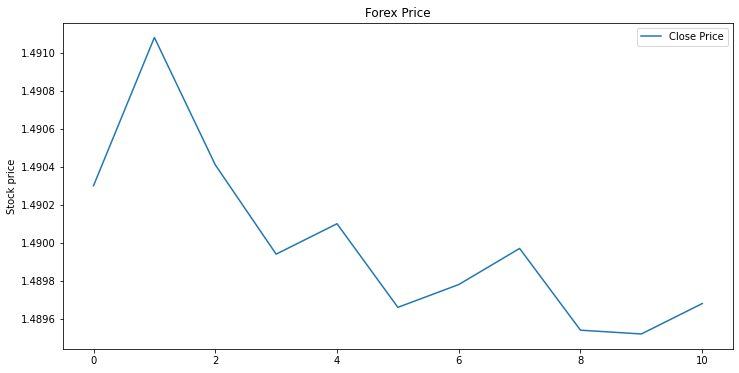

In [ ]:

plt.figure(figsize=(12,6))
plt.title('Forex Price')
plt.ylabel('Stock price')
#plt.plot(range(df_stock.shape[0]),df_stock.Open, label='Open')
#plt.plot(range(df_stock.shape[0]),df_stock.High, label='High')
#plt.plot(range(df_stock.shape[0]),df_stock.Low, label='Low')
plt.plot(range(11),df_stock.close.head(11), label='Close Price')   # use head or tail function to plot beginning or ending of the data
#plt.plot(range(df_stock.shape[0]),df_stock.Close, label='Close')
plt.legend()
plt.show()

### Intercative chart for stock price

In [ ]:
df = df_stock

## set the index
df = df.set_index(pd.DatetimeIndex(df['date'].values))
figure = go.Figure(data = [
    go.Candlestick(x = df.index,
                   open = df.open,
                   low = df.low,
                   high = df.high,
                   close = df.close,
                   increasing_line_color = 'orange',
                   decreasing_line_color = 'black')
])
#figure.update_layout(xaxis_rangeslider_visible = False)
figure.update_layout(title = "Apple Stock Price",
                    xaxis_title = 'Date',
                    yaxis_title = 'Stock Price')
figure.show()


In [ ]:
def price_sequence(close_price,num_days):
    
    '''Input: the price variable and num_days  
      'num_days': determines the # historical price point that we want to use to predict following price point in the future
       Output: X: Convert the price variable into an array of [num_days x 1] dimension 
               y: Convert the price variable into an 1D array (vector)
       Example: If y[t] represent today's price point, 
                corresponding X[t-1] represent last 10 historical price point from t-10 to t-1 given num_days =10
    '''
    
    
    X, y = [], []
    for i in range(len(close_price)-num_days):
        #Taking the 8th day as the label if the previous 7 days are features
        y.append(close_price[i+num_days])
        holder = []
        for j in range(i,i+num_days):
            holder.append(close_price[j])
        X.append(holder)
        
    return array(X), array(y)

def unfold_data(X,y):
    
    '''Input: 2 Arrays  
       Output: Displays unfolded data
    '''
    
    for i in range(len(X)):
        print(X[i],y[i])


In [ ]:
### 

num_days = 10   # to predict today's price based on last 10 days of prices
n_features = 1 ##Considering only close price

X, y = price_sequence(df_stock["close"], num_days)
#unfold_data(X,y)
print(X[0])
print(y[0])

[1.4903  1.49108 1.49041 1.48994 1.4901  1.48966 1.48978 1.48997 1.48954
 1.48952]
1.48968


### Split dataset into training and test set

In [ ]:

# X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
history = int(len(y)*0.8) 
X_train = np.asarray(X[:history])
X_test = np.asarray(X[history:])
y_train = np.asarray(y[:history])
y_test = np.asarray(y[history:])


print("Shape of X_train: {}".format(np.shape(X_train)))
print("Shape of X_test: {}".format(np.shape(X_test)))
print("Shape of y_train: {}".format(np.shape(y_train)))
print("Shape of y_test: {}".format(np.shape(y_test)))

Shape of X_train: (79992, 10)
Shape of X_test: (19998, 10)
Shape of y_train: (79992,)
Shape of y_test: (19998,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

In [ ]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_confidence = rf.score(X_test, y_test)

In [ ]:
print(rf_confidence)

0.9994875580008251


In [ ]:
rg = Ridge()
rg.fit(X_train, y_train)
rg_confidence = rg.score(X_test, y_test)

In [ ]:
svr = SVR()
svr.fit(X_train, y_train)
svr_confidence = svr.score(X_test, y_test)

In [ ]:
model = LinearRegression().fit(X_train, y_train)
r_sq = model.score(X_test, y_test)

In [ ]:
names = ['Linear Regression', 'Random Forest', 'Ridge', 'SVR']
columns = ['model', 'accuracy']
scores = [r_sq, rf_confidence, rg_confidence, svr_confidence]
alg_vs_score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
alg_vs_score

model  accuracy
0  Linear Regression  0.999580
1      Random Forest  0.999491
2              Ridge  0.999036
3                SVR -1.452105

Overfitting problem occurs when I try train_test_split method. 
Lets try without splitting

In [ ]:
df_stock

index                            date     open     high      low  \
0           1  2015-12-18T16:30:00.000000000Z  1.49088  1.49146  1.49028   
1           2  2015-12-18T16:45:00.000000000Z  1.49036  1.49118  1.48998   
2           3  2015-12-18T17:00:00.000000000Z  1.49114  1.49164  1.49041   
3           4  2015-12-18T17:15:00.000000000Z  1.49036  1.49058  1.48986   
4           5  2015-12-18T17:30:00.000000000Z  1.49000  1.49023  1.48956   
...       ...                             ...      ...      ...      ...   
99995   99996  2019-12-30T22:30:00.000000000Z  1.31173  1.31195  1.31162   
99996   99997  2019-12-30T22:45:00.000000000Z  1.31196  1.31220  1.31175   
99997   99998  2019-12-30T23:00:00.000000000Z  1.31204  1.31204  1.31168   
99998   99999  2019-12-30T23:15:00.000000000Z  1.31164  1.31186  1.31148   
99999  100000  2019-12-30T23:30:00.000000000Z  1.31186  1.31186  1.31100   

         close  volume  
0      1.49030     226  
1      1.49108     194  
2      1.49041     151  
3      1.48994     107  
4      1.49010     111  
...        ...     ...  
99995  1.31191      44  
99996  1.31209      46  
99997  1.31168      36  
99998  1.31184      29  
99999  1.31115      67  

[100000 rows x 7 columns]

In [ ]:
X = df_stock.drop('close', axis=1)
y = df_stock['close']

In [ ]:
X.set_index('date', inplace=True)

In [ ]:
rf = RandomForestRegressor()
dd = rf.fit(X, y)
rf_confidence = rf.score(X, y)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dd, X, y, cv=10)

In [ ]:
print(scores)

[0.99950561 0.99982911 0.9992053  0.99981083 0.99970488 0.99916369
 0.99970928 0.99956931 0.99988986 0.99988235]


Classification 

In [ ]:
#Create the target column
df_stock['Target'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0) # if tomorrows price is greater than todays price put 1 else put 0
#Remove the date column
#remove_list = ['Date'] 
#df = df.drop(columns=remove_list)
#Show the data
df_stock

index                            date     open     high      low  \
0           1  2015-12-18T16:30:00.000000000Z  1.49088  1.49146  1.49028   
1           2  2015-12-18T16:45:00.000000000Z  1.49036  1.49118  1.48998   
2           3  2015-12-18T17:00:00.000000000Z  1.49114  1.49164  1.49041   
3           4  2015-12-18T17:15:00.000000000Z  1.49036  1.49058  1.48986   
4           5  2015-12-18T17:30:00.000000000Z  1.49000  1.49023  1.48956   
...       ...                             ...      ...      ...      ...   
99995   99996  2019-12-30T22:30:00.000000000Z  1.31173  1.31195  1.31162   
99996   99997  2019-12-30T22:45:00.000000000Z  1.31196  1.31220  1.31175   
99997   99998  2019-12-30T23:00:00.000000000Z  1.31204  1.31204  1.31168   
99998   99999  2019-12-30T23:15:00.000000000Z  1.31164  1.31186  1.31148   
99999  100000  2019-12-30T23:30:00.000000000Z  1.31186  1.31186  1.31100   

         close  volume  Target  
0      1.49030     226       1  
1      1.49108     194       0  
2      1.49041     151       0  
3      1.48994     107       1  
4      1.49010     111       0  
...        ...     ...     ...  
99995  1.31191      44       1  
99996  1.31209      46       0  
99997  1.31168      36       1  
99998  1.31184      29       0  
99999  1.31115      67       0  

[100000 rows x 8 columns]

In [ ]:
df_stock['Target'].value_counts()

0    50849
1    49151
Name: Target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


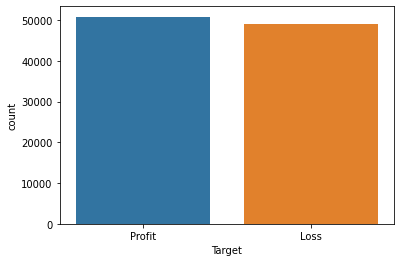

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.countplot(df_stock['Target'])
g.set_xticklabels(['Profit','Loss'])
plt.show()

In [ ]:
def price_sequence(close_price,num_days):
    
    '''Input: the price variable and num_days  
      'num_days': determines the # historical price point that we want to use to predict following price point in the future
       Output: X: Convert the price variable into an array of [num_days x 1] dimension 
               y: Convert the price variable into an 1D array (vector)
       Example: If y[t] represent today's price point, 
                corresponding X[t-1] represent last 10 historical price point from t-10 to t-1 given num_days =10
    '''
    
    
    X, y = [], []
    for i in range(len(close_price)-num_days):
        #Taking the 8th day as the label if the previous 7 days are features
        y.append(close_price[i+num_days])
        holder = []
        for j in range(i,i+num_days):
            holder.append(close_price[j])
        X.append(holder)
        
    return array(X), array(y)

def unfold_data(X,y):
    
    '''Input: 2 Arrays  
       Output: Displays unfolded data
    '''
    
    for i in range(len(X)):
        print(X[i],y[i])

In [ ]:
### 

num_days = 10   # to predict today's price based on last 10 days of prices
n_features = 1 ##Considering only close price

X, y = price_sequence(df_stock["Target"], num_days)
#unfold_data(X,y)
print(X[0])
print(y[0])

[1 0 0 1 0 1 1 0 0 1]
1


In [ ]:
# X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
history = int(len(y)*0.8) 
X_train = np.asarray(X[:history])
X_test = np.asarray(X[history:])
y_train = np.asarray(y[:history])
y_test = np.asarray(y[history:])


print("Shape of X_train: {}".format(np.shape(X_train)))
print("Shape of X_test: {}".format(np.shape(X_test)))
print("Shape of y_train: {}".format(np.shape(y_train)))
print("Shape of y_test: {}".format(np.shape(y_test)))

Shape of X_train: (79992, 10)
Shape of X_test: (19998, 10)
Shape of y_train: (79992,)
Shape of y_test: (19998,)


In [ ]:
from sklearn.preprocessing import StandardScaler #standardscaler removes the mean, and scale the data to the variance 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
model = classifier.fit(X_train, y_train)
cl_sq = model.score(X_test,y_test)

#model = LinearRegression().fit(X_train, y_train)
#r_sq = model.score(X_test, y_test)

In [ ]:
y_pred  =  classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[5715 4554]
 [4955 4774]]


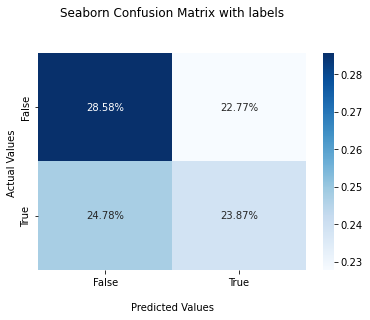

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Support vector machine 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
model = regressor.fit(X_train, y_train)
svr_sq = model.score(X_test,y_test)

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
model = clf.fit(X_train, y_train)
rdmf_sq = model.score(X_test,y_test)

Decision Tree classifier 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
model = clf.fit(X_train,y_train)
sec_sq = model.score(X_test,y_test)

Logistic regression classifier 

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
model = clf.fit(X_train,y_train)
logg_sq = model.score(X_test,y_test)

Final Comparison

In [ ]:
names = ['naive Bayes classification', 'Support Vector Machine', 'Random Forest Classifier', 'Decision Tree classifier', 'Logistic Regression Classifier']
columns = ['model', 'accuracy']
scores = [cl_sq, svr_sq, rdmf_sq, sec_sq, logg_sq]
alg_vs_score = pd.DataFrame([[x, y] for x, y in zip(names, scores)], columns = columns)
alg_vs_score

model  accuracy
0      naive Bayes classification  0.524502
1          Support Vector Machine -0.400656
2        Random Forest Classifier  0.526053
3        Decision Tree classifier  0.509651
4  Logistic Regression Classifier  0.527803